In [1]:
import librosa # for mel-spectrogram estimation
import soundfile # for opening .flac audio
from matplotlib import pyplot as plt
import numpy as np

from IPython.display import Audio

In [2]:
clean_sound, sr_clean = librosa.load("/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/explore_data/explore_data/audio_samples/20-205-0000.flac", sr=16000)
noisy_sound, sr_noisy = librosa.load("/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/explore_data/explore_data/audio_samples/20-205-0000_noisy.wav", sr=16000)
Audio(data=clean_sound, rate=sr_clean)

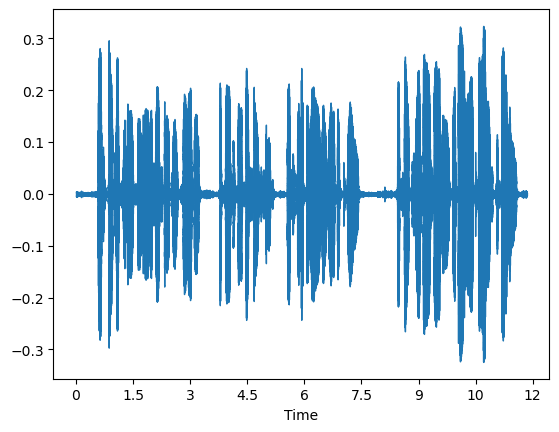

In [7]:
import librosa.display
librosa.display.waveshow(clean_sound, sr=16000)

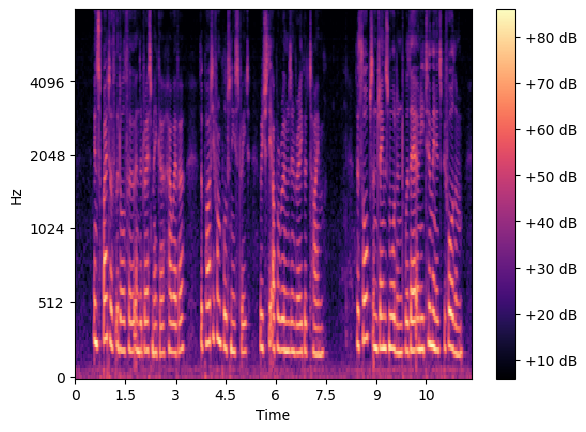

In [8]:
sgram = librosa.stft(clean_sound)
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=16000)

mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [9]:
mel_sgram.shape

(128, 371)

In [10]:
Audio(data=noisy_sound, rate=sr_noisy)

In [11]:
print(f"Clean len sound: {len(clean_sound) / float(sr_clean)}")
print(f"Noisy len sound: {len(noisy_sound) / float(sr_noisy)}")

Clean len sound: 11.85
Noisy len sound: 11.85


In [12]:
clean_audio, framerate = soundfile.read("/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/explore_data/explore_data/audio_samples/20-205-0000.flac")

## Loading npy files (sampling rate is 16k)

In [13]:
rand_sample1_clean = np.load("/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/clean/20/20_205_20-205-0004.npy").astype(np.float32)
rand_sample1_noisy = np.load("/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/noisy/20/20_205_20-205-0004.npy").astype(np.float32)

print(rand_sample1_clean.shape)
print(rand_sample1_noisy.shape)

(875, 80)
(875, 80)


In [14]:
rand_sample2_clean = np.load("/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/clean/8671/8671_285138_8671-285138-0060.npy")
rand_sample2_noisy = np.load("/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/noisy/8671/8671_285138_8671-285138-0060.npy")
print(rand_sample2_clean.shape)
print(rand_sample2_noisy.shape)

(816, 80)
(816, 80)


#### First sample

Text(0.5, 1.0, 'Noisy mel')

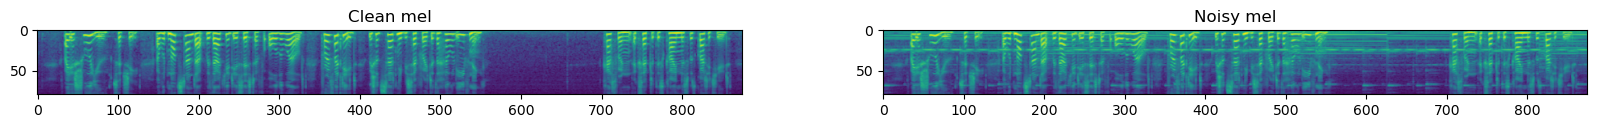

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(rand_sample1_clean.T) #rand_sample1_clean
ax1.set_title("Clean mel")
ax2.imshow(rand_sample1_noisy.T)
ax2.set_title("Noisy mel")

#### Second sample

Text(0.5, 1.0, 'Noisy mel')

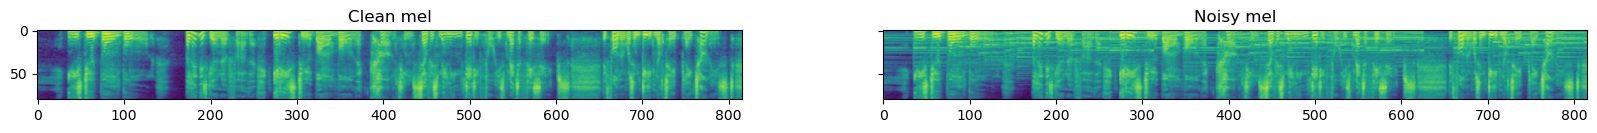

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
ax1.imshow(rand_sample2_clean.T)
ax1.set_title("Clean mel")
ax2.imshow(rand_sample2_noisy.T)
ax2.set_title("Noisy mel")

#### Since numpy array is (x, 80) -> this means that we have 80 time sections. Each time section represents corresp. FFT. Each of x rows represents amplitude values for a frequency band.

In [17]:
import os

noisy_class = os.listdir('/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/' + 'noisy/')
clean_class = os.listdir('/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/' + 'clean/')

noisy_class.sort()
clean_class.sort()

In [18]:
dir_noisy = np.array(['Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/' + 'noisy/' + name for name in noisy_class])
dir_clean = np.array(['Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/' + 'clean/' + name for name in clean_class])

In [22]:
len(dir_clean)

799

In [23]:
import pandas as pd

df = pd.DataFrame({'All_samples': np.hstack((dir_clean, dir_noisy)), 'labels': np.block([np.ones(len(dir_clean)), np.zeros(len(dir_noisy))])})

In [24]:
df['labels'].iloc[798]

1.0

### Creating Dataset

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import typing as tp

In [81]:
class ClassificationSound(Dataset):
    
    def __init__(self, path_to_train: str):
        '''
        Specify path to training data. Folder that contains clean/noisy as subfolders
        '''
        super().__init__()
        self.path_to_train = path_to_train
        clean_class = os.listdir(os.path.join(self.path_to_train, 'clean/'))
        noisy_class = os.listdir(os.path.join(path_to_train, 'noisy/'))
        
        dir_clean = np.array([os.path.join(path_to_train, 'clean', speaker_id, speaker_sample) for speaker_id in sorted(clean_class) for speaker_sample in os.listdir(os.path.join(path_to_train, 'clean', speaker_id))])
        dir_noisy = np.array([os.path.join(path_to_train, 'noisy', speaker_id, speaker_sample) for speaker_id in sorted(noisy_class)for speaker_sample in os.listdir(os.path.join(path_to_train, 'clean', speaker_id))])

        self.dataframe = pd.DataFrame({'All_samples': np.hstack((dir_clean, dir_noisy)), 'labels': np.block([np.ones(len(dir_clean)), np.zeros(len(dir_noisy))])})
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx) -> tp.Tuple[torch.Tensor, torch.Tensor]:
        sample = np.load(self.dataframe['All_samples'].iloc[idx]).T
        
        # Resize and truncate to make same length
        processed_sample = self._process(sample)
        processed_sample = torch.from_numpy(processed_sample).unsqueeze(0)
        
        return processed_sample, torch.from_numpy(np.array(self.dataframe['labels'].iloc[idx]))
        
    @staticmethod
    def _process(sample: np.ndarray) -> np.ndarray:
        '''
        Method for truncating/shifting sample
        '''
        if sample.shape[1] < 700:
            processed_sample = np.pad(sample, ((0, 0), (0, 700 - sample.shape[1])))
        else:
            processed_sample = sample[:, :700]
        return processed_sample

In [82]:
ds_speech_train = ClassificationSound('/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/')

In [83]:
ds_speech_loader_train = DataLoader(ds_speech_train, batch_size=256, shuffle=True)

In [84]:
next(iter(ds_speech_loader_train))[0].shape

torch.Size([256, 1, 80, 700])

In [85]:
ds_speech_val = ClassificationSound('/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/val/val/val')
ds_speech_loader_val = DataLoader(ds_speech_val, batch_size=256, shuffle=True)

In [86]:
next(iter(ds_speech_loader_val))[1].shape

torch.Size([256])

In [87]:
# Simple NN, without anything special
custom_model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), bias=True),
    nn.LeakyReLU(),
    
    nn.MaxPool2d(kernel_size=5, stride=2),
    nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), bias=True),
    
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=5, stride=3),
    
    nn.Flatten(),
    nn.Linear(in_features=864, out_features=1, bias=True)
).cuda()

In [88]:
x = torch.ones((30, 1, 80, 700)).cuda()
print(custom_model)
custom_model(x).squeeze()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=864, out_features=1, bias=True)
)


tensor([-0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650,
        -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650,
        -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650,
        -0.0650, -0.0650, -0.0650, -0.0650, -0.0650, -0.0650], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [89]:
import math

def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)
            
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 0, Loss on current batch: 1.65, Accuracy Train batch: 0.30
Epoch: 0, Loss on current batch: 1.44, Accuracy Train batch: 0.31
Epoch: 0, Loss on current batch: 1.49, Accuracy Train batch: 0.33
Epoch: 0, Loss on current batch: 1.54, Accuracy Train batch: 0.27
Epoch: 0, Loss on current batch: 1.42, Accuracy Train batch: 0.30
Epoch: 0, Loss on current batch: 1.36, Accuracy Train batch: 0.30
Epoch: 0, Loss on current batch: 1.39, Accuracy Train batch: 0.35
Epoch: 0, Loss on current batch: 1.34, Accuracy Train batch: 0.30
Epoch: 0, Loss on current batch: 1.45, Accuracy Train batch: 0.29
Epoch: 0, Loss on current batch: 1.38, Accuracy Train batch: 0.32
Epoch: 0, Loss on current batch: 1.45, Accuracy Train batch: 0.33
Epoch: 0, Loss on current batch: 1.39, Accuracy Train batch: 0.30
Epoch: 0, Loss on current batch: 1.18, Accuracy Train batch: 0.40
Epoch: 0, Loss on current batch: 1.17, Accuracy Train batch: 0.42
Epoch: 0, Loss on current batch: 1.15, Accuracy Train batch: 0.44
Epoch: 0, 

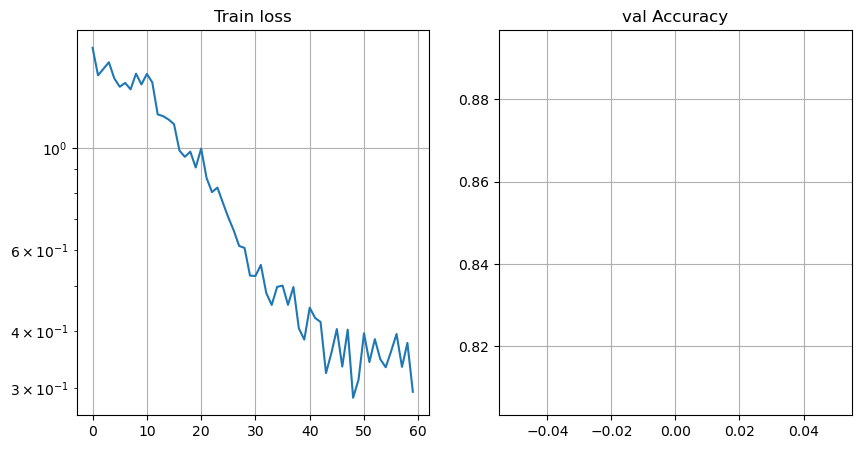

Epoch: 0, Loss on current batch: 0.39, Accuracy Train batch: 0.85
Epoch: 0, Loss on current batch: 0.37, Accuracy Train batch: 0.83
Epoch: 0, Loss on current batch: 0.36, Accuracy Train batch: 0.86
Epoch: 0, Loss on current batch: 0.35, Accuracy Train batch: 0.85
Epoch: 0, Loss on current batch: 0.25, Accuracy Train batch: 0.88
Epoch: 0, Loss on current batch: 0.45, Accuracy Train batch: 0.82
Epoch: 0, Loss on current batch: 0.30, Accuracy Train batch: 0.88
Epoch: 0, Loss on current batch: 0.30, Accuracy Train batch: 0.88
Epoch: 0, Loss on current batch: 0.34, Accuracy Train batch: 0.87
Epoch: 0, Loss on current batch: 0.27, Accuracy Train batch: 0.86
Epoch: 0, Loss on current batch: 0.27, Accuracy Train batch: 0.87
Epoch: 0, Loss on current batch: 0.40, Accuracy Train batch: 0.87
Epoch: 0, Loss on current batch: 0.30, Accuracy Train batch: 0.87
Epoch: 0, Loss on current batch: 0.33, Accuracy Train batch: 0.86
Epoch: 0, Loss on current batch: 0.39, Accuracy Train batch: 0.80
Epoch: 0, 

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1, Loss on current batch: 0.32, Accuracy Train batch: 0.88
Epoch: 1, Loss on current batch: 0.31, Accuracy Train batch: 0.85
Epoch: 1, Loss on current batch: 0.31, Accuracy Train batch: 0.83
Epoch: 1, Loss on current batch: 0.30, Accuracy Train batch: 0.86
Epoch: 1, Loss on current batch: 0.43, Accuracy Train batch: 0.83
Epoch: 1, Loss on current batch: 0.29, Accuracy Train batch: 0.87
Epoch: 1, Loss on current batch: 0.29, Accuracy Train batch: 0.86
Epoch: 1, Loss on current batch: 0.30, Accuracy Train batch: 0.86
Epoch: 1, Loss on current batch: 0.39, Accuracy Train batch: 0.85
Epoch: 1, Loss on current batch: 0.33, Accuracy Train batch: 0.87
Epoch: 1, Loss on current batch: 0.27, Accuracy Train batch: 0.91
Epoch: 1, Loss on current batch: 0.31, Accuracy Train batch: 0.89
Epoch: 1, Loss on current batch: 0.27, Accuracy Train batch: 0.89
Epoch: 1, Loss on current batch: 0.30, Accuracy Train batch: 0.89
Epoch: 1, Loss on current batch: 0.35, Accuracy Train batch: 0.84
Epoch: 1, 

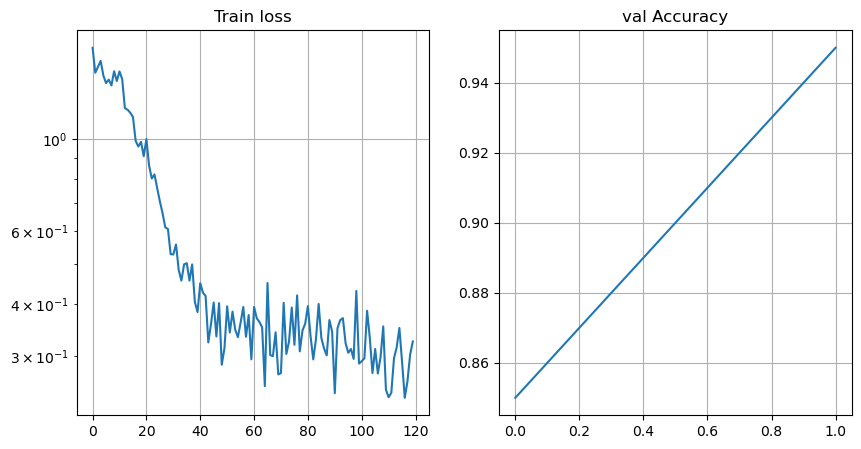

Epoch: 1, Loss on current batch: 0.23, Accuracy Train batch: 0.91
Epoch: 1, Loss on current batch: 0.31, Accuracy Train batch: 0.89
Epoch: 1, Loss on current batch: 0.27, Accuracy Train batch: 0.88
Epoch: 1, Loss on current batch: 0.28, Accuracy Train batch: 0.87
Epoch: 1, Loss on current batch: 0.20, Accuracy Train batch: 0.91
Epoch: 1, Loss on current batch: 0.29, Accuracy Train batch: 0.88
Epoch: 1, Loss on current batch: 0.22, Accuracy Train batch: 0.88
Epoch: 1, Loss on current batch: 0.22, Accuracy Train batch: 0.91
Epoch: 1, Loss on current batch: 0.30, Accuracy Train batch: 0.88
Epoch: 1, Loss on current batch: 0.29, Accuracy Train batch: 0.86
Epoch: 1, Loss on current batch: 0.27, Accuracy Train batch: 0.90
Epoch: 1, Loss on current batch: 0.23, Accuracy Train batch: 0.92
Epoch: 1, Loss on current batch: 0.29, Accuracy Train batch: 0.87
Epoch: 1, Loss on current batch: 0.20, Accuracy Train batch: 0.90
Epoch: 1, Loss on current batch: 0.31, Accuracy Train batch: 0.87
Epoch: 1, 

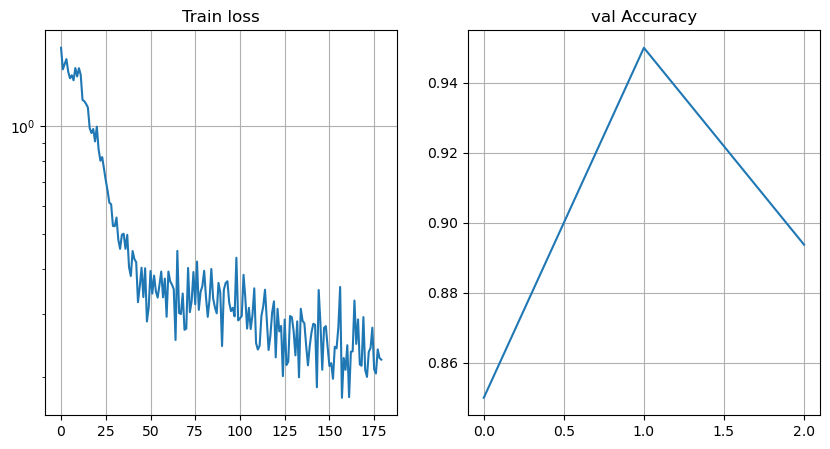

Epoch: 1, Loss on current batch: 0.28, Accuracy Train batch: 0.86
Epoch: 1, Loss on current batch: 0.21, Accuracy Train batch: 0.90
Epoch: 1, Loss on current batch: 0.23, Accuracy Train batch: 0.91
Epoch: 1, Loss on current batch: 0.26, Accuracy Train batch: 0.91
Epoch: 1, Loss on current batch: 0.22, Accuracy Train batch: 0.92
Epoch: 1, Loss on current batch: 0.24, Accuracy Train batch: 0.90
Epoch: 1, Loss on current batch: 0.19, Accuracy Train batch: 0.92
Epoch: 1, Loss on current batch: 0.27, Accuracy Train batch: 0.91


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 2, Loss on current batch: 0.22, Accuracy Train batch: 0.91
Epoch: 2, Loss on current batch: 0.25, Accuracy Train batch: 0.86
Epoch: 2, Loss on current batch: 0.23, Accuracy Train batch: 0.91
Epoch: 2, Loss on current batch: 0.21, Accuracy Train batch: 0.90
Epoch: 2, Loss on current batch: 0.20, Accuracy Train batch: 0.91
Epoch: 2, Loss on current batch: 0.24, Accuracy Train batch: 0.92
Epoch: 2, Loss on current batch: 0.22, Accuracy Train batch: 0.90
Epoch: 2, Loss on current batch: 0.23, Accuracy Train batch: 0.87
Epoch: 2, Loss on current batch: 0.18, Accuracy Train batch: 0.93
Epoch: 2, Loss on current batch: 0.21, Accuracy Train batch: 0.94
Epoch: 2, Loss on current batch: 0.20, Accuracy Train batch: 0.94
Epoch: 2, Loss on current batch: 0.15, Accuracy Train batch: 0.92
Epoch: 2, Loss on current batch: 0.17, Accuracy Train batch: 0.91
Epoch: 2, Loss on current batch: 0.19, Accuracy Train batch: 0.91
Epoch: 2, Loss on current batch: 0.21, Accuracy Train batch: 0.93
Epoch: 2, 

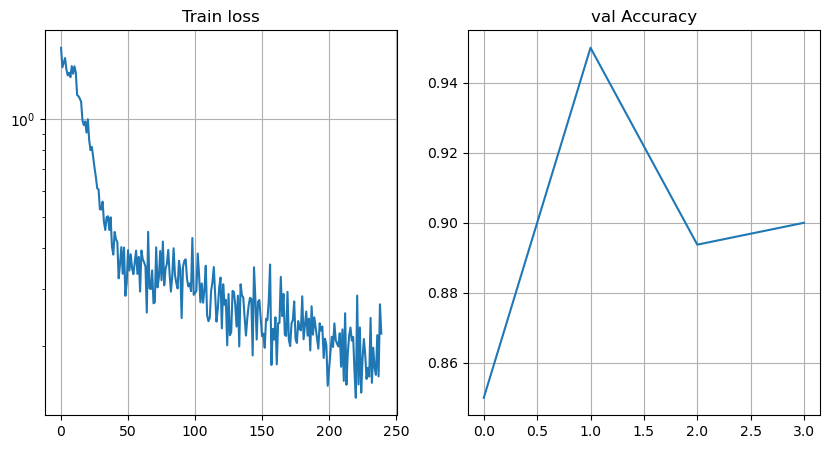

Epoch: 2, Loss on current batch: 0.19, Accuracy Train batch: 0.90
Epoch: 2, Loss on current batch: 0.23, Accuracy Train batch: 0.88
Epoch: 2, Loss on current batch: 0.24, Accuracy Train batch: 0.89
Epoch: 2, Loss on current batch: 0.17, Accuracy Train batch: 0.95
Epoch: 2, Loss on current batch: 0.23, Accuracy Train batch: 0.95
Epoch: 2, Loss on current batch: 0.22, Accuracy Train batch: 0.91
Epoch: 2, Loss on current batch: 0.18, Accuracy Train batch: 0.92
Epoch: 2, Loss on current batch: 0.28, Accuracy Train batch: 0.84
Epoch: 2, Loss on current batch: 0.27, Accuracy Train batch: 0.85
Epoch: 2, Loss on current batch: 0.18, Accuracy Train batch: 0.93
Epoch: 2, Loss on current batch: 0.24, Accuracy Train batch: 0.93
Epoch: 2, Loss on current batch: 0.19, Accuracy Train batch: 0.95
Epoch: 2, Loss on current batch: 0.17, Accuracy Train batch: 0.93
Epoch: 2, Loss on current batch: 0.19, Accuracy Train batch: 0.90
Epoch: 2, Loss on current batch: 0.26, Accuracy Train batch: 0.87
Epoch: 2, 

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 3, Loss on current batch: 0.19, Accuracy Train batch: 0.91
Epoch: 3, Loss on current batch: 0.18, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.18, Accuracy Train batch: 0.93
Epoch: 3, Loss on current batch: 0.25, Accuracy Train batch: 0.91
Epoch: 3, Loss on current batch: 0.11, Accuracy Train batch: 0.97
Epoch: 3, Loss on current batch: 0.18, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.16, Accuracy Train batch: 0.93
Epoch: 3, Loss on current batch: 0.25, Accuracy Train batch: 0.89
Epoch: 3, Loss on current batch: 0.13, Accuracy Train batch: 0.95
Epoch: 3, Loss on current batch: 0.17, Accuracy Train batch: 0.91
Epoch: 3, Loss on current batch: 0.18, Accuracy Train batch: 0.93
Epoch: 3, Loss on current batch: 0.19, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.26, Accuracy Train batch: 0.91
Epoch: 3, Loss on current batch: 0.21, Accuracy Train batch: 0.89
Epoch: 3, Loss on current batch: 0.15, Accuracy Train batch: 0.93
Epoch: 3, 

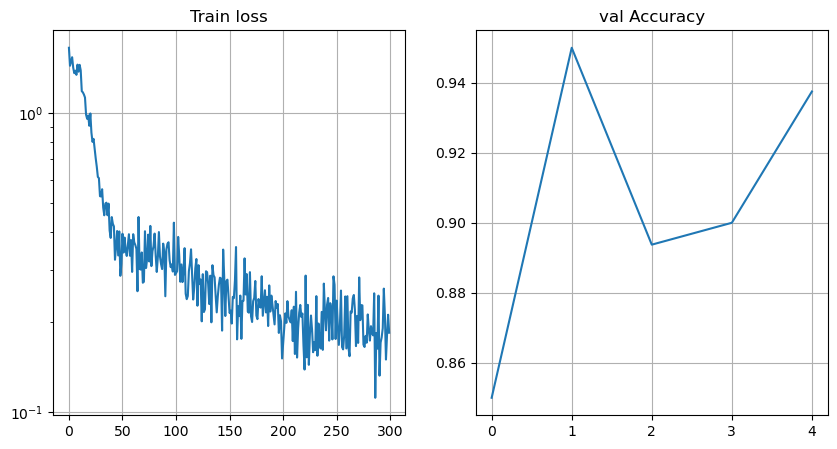

Epoch: 3, Loss on current batch: 0.25, Accuracy Train batch: 0.91
Epoch: 3, Loss on current batch: 0.17, Accuracy Train batch: 0.95
Epoch: 3, Loss on current batch: 0.16, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.20, Accuracy Train batch: 0.92
Epoch: 3, Loss on current batch: 0.19, Accuracy Train batch: 0.92
Epoch: 3, Loss on current batch: 0.23, Accuracy Train batch: 0.90
Epoch: 3, Loss on current batch: 0.15, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.20, Accuracy Train batch: 0.93
Epoch: 3, Loss on current batch: 0.21, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.19, Accuracy Train batch: 0.92
Epoch: 3, Loss on current batch: 0.16, Accuracy Train batch: 0.91
Epoch: 3, Loss on current batch: 0.14, Accuracy Train batch: 0.95
Epoch: 3, Loss on current batch: 0.12, Accuracy Train batch: 0.96
Epoch: 3, Loss on current batch: 0.17, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.14, Accuracy Train batch: 0.94
Epoch: 3, 

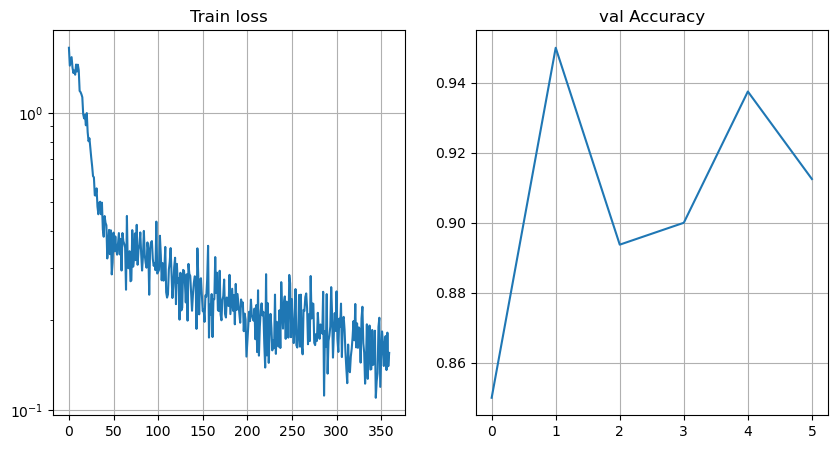

Epoch: 3, Loss on current batch: 0.20, Accuracy Train batch: 0.91
Epoch: 3, Loss on current batch: 0.14, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.13, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.16, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.12, Accuracy Train batch: 0.96
Epoch: 3, Loss on current batch: 0.15, Accuracy Train batch: 0.93
Epoch: 3, Loss on current batch: 0.15, Accuracy Train batch: 0.95
Epoch: 3, Loss on current batch: 0.15, Accuracy Train batch: 0.95
Epoch: 3, Loss on current batch: 0.13, Accuracy Train batch: 0.95
Epoch: 3, Loss on current batch: 0.12, Accuracy Train batch: 0.95
Epoch: 3, Loss on current batch: 0.19, Accuracy Train batch: 0.91
Epoch: 3, Loss on current batch: 0.12, Accuracy Train batch: 0.95
Epoch: 3, Loss on current batch: 0.15, Accuracy Train batch: 0.94
Epoch: 3, Loss on current batch: 0.18, Accuracy Train batch: 0.92
Epoch: 3, Loss on current batch: 0.17, Accuracy Train batch: 0.94


KeyboardInterrupt: 

In [133]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

#Convergence much faster using xavier initialization of NN weights

xavier_init(custom_model)
#kaiming_init(custom_model)

optimizer = torch.optim.AdamW(custom_model.parameters(), lr=3e-4)

num_epochs = 7
loss_fn = nn.BCEWithLogitsLoss()

acc = []
train_loss = []

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(ds_speech_loader_train)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

plotting = 0
for epoch in range(num_epochs):
    for x, y in tqdm(ds_speech_loader_train):
        custom_model.train()
        x = x.cuda()
        y = y.cuda()

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            predict = custom_model(x)
            loss = loss_fn(predict.squeeze(), y)
            
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        #print(f"Loss on current batch: {loss.item()}")
        train_loss.append(loss.item())
        
        acc_train = torch.where(predict > 0.5, 1, 0).squeeze()
        acc_train_metric = accuracy_score(y.detach().cpu().numpy(), acc_train.detach().cpu().numpy().ravel())
        
        print(f'Epoch: {epoch}, Loss on current batch: {loss.item():.2f}, Accuracy Train batch: {acc_train_metric:.2f}')
        with torch.no_grad():
            for x_val, y_val in ds_speech_loader_val:
                with torch.cuda.amp.autocast():
                    x_val = x_val.cuda()
                    y_val = y_val.cuda()
                    val_predict = custom_model(x_val)
                    val_predict = torch.where(val_predict > 0.5, 1, 0).squeeze()
        
        plotting += 1
        if plotting % 60 == 0:
            print('Epoch: ', epoch)
            acc.append(accuracy_score(y_val.detach().cpu().numpy(), val_predict.detach().cpu().numpy().ravel()))
            plt.figure(figsize=(10,5))
            plt.subplot(121)
            plt.semilogy(train_loss)
            plt.title('Train loss')
            plt.grid()
            plt.subplot(122)
            plt.plot(acc)
            plt.title('val Accuracy')
            plt.grid()
            plt.show()

In [ ]:
torch.save(custom_model.state_dict(), "custom_model.pth")

In [ ]:
custom_model.load_state_dict(torch.load("custom_model.pth"))
custom_model.eval()

In [ ]:
test1 = np.load("/home/m_bobrin/goznak/Task2Noise_Speech/Goznak_ML_Tasks/train1/train/train/clean/51/51_121055_51-121055-0065.npy").astype(np.float32)
test1.shape

In [ ]:
sample = test1.T
if sample.shape[1] < 700:
    processed_sample = np.pad(sample, ((0, 0), (0, 700 - sample.shape[1])))
else:
    processed_sample = sample[:, :700]

In [ ]:
torch.sigmoid(custom_model(torch.from_numpy(processed_sample).unsqueeze(0).unsqueeze(1).cuda())).item()

In [130]:
custom_model.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('0',
               Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))),
              ('1', LeakyReLU(negative_slope=0.01)),
              ('2',
               MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)),
              ('3', Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))),
              ('4', LeakyReLU(negative_slope=0.01)),
              ('5',
               MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)),
              ('6', Flatten(start_dim=1, end_dim=-1)),
              ('7', Linear(in_features=864, out_features=